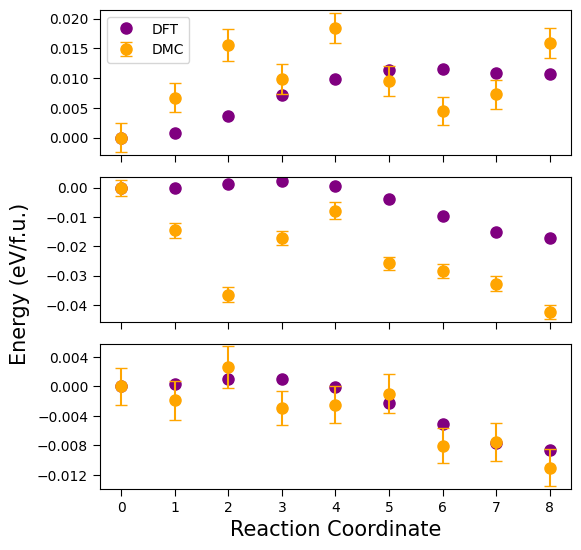

In [34]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

RY_TO_EV = 13.605693122994
NUM_FU = 8
folders = ["barrier", "barrier2", "barrier3"]

def parse_dft(folder):
    path = os.path.join(folder, "DFT_result")
    dft_energies = []
    if not os.path.exists(path):
        return np.array([])
    with open(path, "r") as f:
        for line in f:
            match = re.search(r"total energy\s*=\s*([-0-9.]+)\s*Ry", line)
            if match:
                energy_ry = float(match.group(1))
                energy_ev = energy_ry * RY_TO_EV / NUM_FU
                dft_energies.append(energy_ev)
    return np.array(dft_energies)

def parse_dmc(folder):
    path = os.path.join(folder, "DMC_result")
    dmc_energies, dmc_errors = [], []
    if not os.path.exists(path):
        return np.array([]), np.array([])
    with open(path, "r") as f:
        for line in f:
            match = re.search(r"config\s+\d+:\s+([-0-9.]+)\s+([0-9.]+)", line)
            if match:
                energy = float(match.group(1)) / NUM_FU
                error = float(match.group(2)) / NUM_FU
                dmc_energies.append(energy)
                dmc_errors.append(error)
    return np.array(dmc_energies), np.array(dmc_errors)

# figsize matching image aspect ratio: 771 / 768 ≈ 1.0039
figsize = (6, 6 * 771 / 768)  # ≈ (6, 6.023)

fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

for i, folder in enumerate(folders):
    dft = parse_dft(folder)
    dmc, dmc_err = parse_dmc(folder)

    if len(dft) == 0 or len(dmc) == 0:
        continue

    dft_rel = dft - dft[0]
    dmc_rel = dmc - dmc[0]
    x = np.arange(len(dft_rel))
    ax = axes[i]

    ax.plot(x, dft_rel, 'o', color="purple", markersize=8, label="DFT" if i == 0 else "")
    ax.errorbar(x, dmc_rel, yerr=dmc_err, fmt='o', color="orange", markersize=8, capsize=4, label="DMC" if i == 0 else "")

    if i == 0:
        ax.legend(loc='upper left', fontsize=10)

    ax.grid(False)
    ax.tick_params(axis='both', which='both', length=5, labelsize=10)

    y_min = np.min(np.concatenate([dft_rel, dmc_rel - dmc_err]))
    y_max = np.max(np.concatenate([dft_rel, dmc_rel + dmc_err]))
    pad = 0.02 * (y_max - y_min)
    ax.set_ylim(y_min - pad, y_max + pad)

    if folder == "barrier3":
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

fig.text(0.04, 0.5, 'Energy (eV/f.u.)', va='center', rotation='vertical', fontsize=15)
axes[-1].set_xlabel("Reaction Coordinate", fontsize=15)

plt.tight_layout(rect=(0.06, 0.05, 1, 0.98))
plt.savefig("LPS_barrier_QMC_DFT.png", dpi=300, bbox_inches='tight')
plt.show()


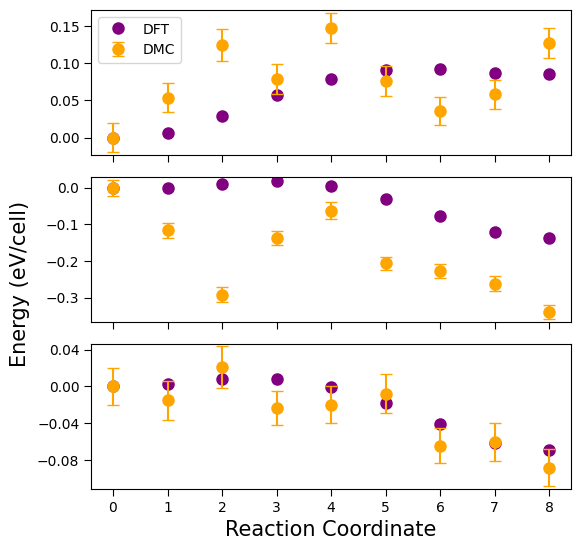

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- Load tidy format CSV ---
df = pd.read_csv("LPS_barrier_integrated.csv")

# --- Ensure correct dtype ---
df["error_ev"] = pd.to_numeric(df["error_ev"], errors='coerce')  # NaN for DFT
df["config"] = df["config"].astype(int)

# --- Define barrier ordering if needed ---
barrier_order = ["barrier", "barrier2", "barrier3"]

# --- Setup plot ---
figsize = (6, 6 * 771 / 768)
fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)

for i, barrier in enumerate(barrier_order):
    ax = axes[i]

    sub_df = df[df["barrier"] == barrier].copy()

    # Split methods
    dft = sub_df[sub_df["method"] == "DFT"].sort_values("config")
    dmc = sub_df[sub_df["method"] == "DMC"].sort_values("config")

    if dft.empty or dmc.empty:
        continue

    # Relative energy
    dft_rel = dft["energy_ev"].to_numpy() - dft["energy_ev"].iloc[0]
    dmc_rel = dmc["energy_ev"].to_numpy() - dmc["energy_ev"].iloc[0]
    dmc_err = dmc["error_ev"].to_numpy()
    x = dft["config"].to_numpy()

    # Plot
    ax.plot(x, dft_rel, 'o', color="purple", markersize=8, label="DFT" if i == 0 else "")
    ax.errorbar(x, dmc_rel, yerr=dmc_err, fmt='o', color="orange", markersize=8, capsize=4, label="DMC" if i == 0 else "")

    if i == 0:
        ax.legend(loc='upper left', fontsize=10)

    ax.grid(False)
    ax.tick_params(axis='both', which='both', length=5, labelsize=10)

    # Axis limits
    y_min = np.min(np.concatenate([dft_rel, dmc_rel - dmc_err]))
    y_max = np.max(np.concatenate([dft_rel, dmc_rel + dmc_err]))
    pad = 0.02 * (y_max - y_min)
    ax.set_ylim(y_min - pad, y_max + pad)

    if barrier == "barrier3":
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))

# Labels
fig.text(0.04, 0.5, 'Energy (eV/cell)', va='center', rotation='vertical', fontsize=15)
axes[-1].set_xlabel("Reaction Coordinate", fontsize=15)

plt.tight_layout(rect=(0.06, 0.05, 1, 0.98))
plt.savefig("LPS_barrier_QMC_DFT.png", dpi=300, bbox_inches='tight')
plt.show()
